# Introduction to Text as Data

## UNM Workshop, April 9, 2018

Alex Hanna, PhD ([Email](alex.hanna@utoronto.ca) | [GitHub](https://github.com/alexhanna) | [Web](alex-hanna.com))

### Learning Objectives

In today's workshop, we're going to combine the [tidyverse workflow](https://cran.r-project.org/web/packages/tidyverse/vignettes/manifesto.html) with a set of common TAD goals. The tidyverse is a group of R packages created by Hadley Wickham and others which prioritizes a common representation of data and data workflows. You should have gotten at least a little bit of exposure to the tidyverse prior to this workshop. If not, that's still fine. But make sure to look up any particular verbs which aren't familiar. 

By the end of the workshop, you should be able 

- understand the data flow of `tidyverse` and `tidytext`
- count the most common words from a particular text
- compare two texts for most common words
- apply a structural topic model to a set of documents using `stm`

### What are Text as Data methods?

Text as data (TAD) methods are a body of different computational methods for doing analysis of natural language. TAD is drawn from a number of different fields, including computational linguistics, natural language processing, and machine learning.

TAD as a body of methods has grown as a means of dealing with large amounts of political and social text. Within sociology, TAD has been largely used as a means of studying culture and institutional logics ([Mohr and Bogdanov 2013](https://www.sciencedirect.com/journal/poetics/vol/41); [Nelson 2017](https://www.sciencedirect.com/journal/poetics/vol/41)). There's been a more widespread adoption of TAD within political science and political methodology more specifically. Earlier interventions into this space focused on ideological scaling ([Laver, Benoit, and Garry 2003](http://faculty.washington.edu/jwilker/tft/Laver.pdf); [Slapin and Proksch 2008](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.704.3894&rep=rep1&type=pdf)), i.e. identifying ideological positions of political actors via some kind of written or spoken text. More recent work has focused on classification of text, either based on known categories or unknown categories. Categories can be diverse as political sentiment towards a particular topic or politician ([Hopkins and King 2010](https://gking.harvard.edu/files/words.pdf)) to types of protest speech ([Hanna 2013](http://alex-hanna.com/static/pdf/Hanna.Moby2013.pdf)) to political credit taking ([Grimmer 2013](http://www.cambridge.org/us/academic/subjects/politics-international-relations/american-government-politics-and-policy/representational-style-congress-what-legislators-say-and-why-it-matters#SlBUdh8bBkEg8eGI.97)). 

There's a separate but related strain of TAD which is less concerned with ideological scaling or categorization and more concerned with event data creation. There's a long history of this methodology, largely pioneered by Phil Schrodt ([2012](https://www.researchgate.net/profile/Philip_Schrodt/publication/254242323_Precedents_Progress_and_Prospects_in_Political_Event_Data/links/543fc29a0cf21227a11b77af/Precedents-Progress-and-Prospects-in-Political-Event-Data.pdf)). This has been a space of intervention for both Dr. Osorio and myself ([Osorio 2016](https://docs.wixstatic.com/ugd/76b255_12d39b7bb99d402687359d72c8a769b9.pdf); [Hanna 2017](https://osf.io/preprints/socarxiv/xuqmv)).

The figure below displays directives of how to choose a particular TAD method for your own purposes. The article from which it comes ([Grimmer and Stewart 2013](https://web.stanford.edu/~jgrimmer/tad2.pdf)) provides an excellent set of procedures for performing TAD transparently, replicably, and validly.

![overview of TAD](img/Grimmer-Stewart-mod.png)

#### Exercise 1

1. I want to classify Congressional press releases based on a classification scheme I've generated through a literature review. Which method(s) could I consider using?
2. I want to generate a set of topics from a bunch of House floor speeches. Which method(s) could I consider using?


### Using `tidytext`

[`tidytext`](https://cran.r-project.org/web/packages/tidytext/vignettes/tidytext.html) is an R package develped by Julia Silge and David Robinson, created for the purpose of integrating text processing methods into the tidyverse. This package allows us to preprocess text in a number of ways, such as converting it to lowercase, removing stopwords, and tokenizing it. It also allows us to convert between different methods for importing into other text packages. We'll get into what this all means below.

Let's start with single text, in this case, Mary Wollenstonecraft's *A Vindication of the Rights of Woman*. This work is considered a cornerstone of political philosophy in first-wave feminism. Inspired by Laura Nelson's own interrogation of feminist texts, let's start digging into some of its language.

First let's load the `tidyverse`, `tidytext`, and `gutenbergr`, a package developed by David Robinson which allows us to easily load in books from Project Gutenberg with only an numerical ID or a title.

In [32]:
library(tidyverse)
library(tidytext)
library(gutenbergr)

Next, we're going to download *Vindication* and convert it to tidy format.

In [33]:
## A Vindication of the Rights of Woman by Mary Wollstonecraft
vindication <- gutenberg_download(3420)

Project Gutenberg gives us a text as a set of lines. Next, we're going to use one of the workhorse "verbs" of `tidytext` to convert text to lowercase and *tokenize* the text.  

On the level of meaning, the lowercase and uppercase of a word generally mean the same thing (sometimes they don't, though. For instance, an SMS saying 'Thank you.' means something different from one saying 'THANK YOU.'). But for the most part, we will want to convert to lowercase.

Secondly, we want to split the text by some kind of rule. This is the process of tokenization. For many applications, we mostly want to split by individual words and remove punctuation. 

`unnest_tokens` takes two mandatory arguments in this format -- the output column name and the input column name. We can call the output column `word`.

In [34]:
tidy_vindication <- vindication %>% 
    unnest_tokens(word, text)

The output of `unnest_tokens` with no other arguments is a list of each word (or token) in order. For some purposes, we may also want to use conjunctions of multiple words, or n-grams. This allows us to have a little more context for the word. For instance, there's more meaning in "white house" than in "white" or "house" alone. 

In [ ]:
vindication %>% unnest_tokens(word, text, token = "ngrams", n = 2)

This one-per-row format lends itself nicely to other functions of the tidyverse. We can now do things like count unique items, join words with other data, and summarize across useful common variables.

The most basic thing we can begin to do is simply count the top words in the text. Using the `count` verb makes this straightforward.

In [ ]:
tidy_vindication %>% count(word, sort = TRUE)

Nothing too exciting here. Most of the top words are common words, like "and" or "the". These are what are known as *stop words* and we typically want to remove them from analysis. Luckily, there's another verb we can use to this, called `anti_join`. Simply put, this will join a dataset on common elements and remove those elements from the dataset. In this case, we'll join the list of English stop words with the list of single words, then we'll count them again.

In [35]:
tidy_vindication <- tidy_vindication %>%
    anti_join(stop_words)

Joining, by = "word"


In [ ]:
tidy_vindication %>% count(word, sort = TRUE)

Now we're getting somewhere. We're getting some important words from this text, such as *women, reason, mind*, and *virtue*.

Lastly, let's look if there are some important bigrams (these are n-grams with length 2) which may be important in this text. We can't just use `anti_join` to remove stop words in this instance. We have to first split each bigram with `separate`, check if each word is in the stop word list with `filter`, then count the word pairs. One of the great things about the tidyverse is that we can stop after each verb and check the output to see if it makes sense.

In [ ]:
## bigram stopword removal
bigrams <- vindication %>%
    unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
    separate(bigram, c("word1", "word2"), sep = " ") %>%
    filter(!word1 %in% stop_words$word) %>%
    filter(!word2 %in% stop_words$word) %>%
    count(word1, word2, sort = TRUE)

In this analysis, we see that Wollstonecraft is using much more universalist language, with *fellow creatures*, *sufficient strength*, and *common sense*.

Now it's your turn!

#### Exercise 2

1. Load another text, *Souls of Black Folks* by W.E.B. DuBois from `gutenbergr`. The ID is 408. Store it in a variable called `souls`.
2. Convert `souls` to a list of words using tidytext and remove the stop words. Store this in `tidy_souls`.
3. Generate a count of the top words. Now, select only the top 20 words in the counted word list. You'll need to use the tidyverse verb `top_n`, which takes a single argument, the number of rows to display.

### Comparing texts

We rarely want to look at a text in isolation. Typically, we want to compare texts across time (e.g. see the change in the prevalence of a topic), across individual authors (e.g. across politicians), or some other variable of interest. For this reason, it's helpful to know how to compare different texts to each other. 

We could do this through a number of methods. We could, for instance, look at common words and compare the proportion of each author's text. Laura K. Nelson, for instance, performs this procedure [as a first step](https://github.com/lknelson/computational-grounded-theory) in comparing texts from different feminist organizations.

Let's load our second first-wave feminist text, *The Subjection of Women* by John Stuart Mill from `gutenbergr` and convert it to tidy format.

In [36]:
subjection <- gutenberg_download(27083)

In [37]:
tidy_subjection <- subjection %>% 
    unnest_tokens(word, text) %>%
    anti_join(stop_words)

Joining, by = "word"


The next thing we're going to do is smush together the tidy data frames for each author.

In [38]:
tidy_books <- bind_rows(mutate(tidy_subjection, author = 'Mills'), 
                        mutate(tidy_vindication, author = 'Wollstonecraft'))

Next, we're going to go through a few different tidy data procedures to compare the two authors. We are first going to count each word but now grouped by author. We then generate a new column with `mutate` which will result in a proportion. We then must remove the column `n` from the analysis for the next few parts to work correctly using `select`. Next we move from a long format to a wide format using `spread`. Spread moves the proportions from a single column to two columns, one for each author. We lastly take the difference between the two proportions and sort them by descending order using `arrange`.

In [82]:
word_proportions <- tidy_books %>% 
    count(word, author) %>%
    group_by(author) %>%
    mutate(proportion = n / sum(n)) %>%
    select(-n) %>%
    spread(author, proportion, fill = 0) %>%
    mutate(diffprop = Mills - Wollstonecraft) %>%
    arrange(desc(diffprop))

word,Mills,Wollstonecraft,diffprop
women,0.022352612,1.333573e-02,0.009016882
law,0.005797709,4.794869e-04,0.005318222
power,0.007893266,2.876922e-03,0.005016345
human,0.007264599,3.086697e-03,0.004177902
social,0.004470522,3.895831e-04,0.004080939
influence,0.004121263,2.697114e-04,0.003851552
persons,0.003772003,6.892625e-04,0.003082741
society,0.005797709,2.757050e-03,0.003040659
individual,0.003213188,6.592946e-04,0.002553893
wife,0.003352892,1.018910e-03,0.002333982


We can see the top (and bottom) 10 in difference of proportion with `head` and `tail`.

In [89]:
word_proportions %>% head(10)

word,Mills,Wollstonecraft,diffprop
women,0.022352612,0.0133357308,0.009016882
law,0.005797709,0.0004794869,0.005318222
power,0.007893266,0.0028769217,0.005016345
human,0.007264599,0.0030866972,0.004177902
social,0.004470522,0.0003895831,0.004080939
influence,0.004121263,0.0002697114,0.003851552
persons,0.003772003,0.0006892625,0.003082741
society,0.005797709,0.0027570500,0.003040659
individual,0.003213188,0.0006592946,0.002553893
wife,0.003352892,0.0010189098,0.002333982


In [90]:
word_proportions %>% tail(10)

word,Mills,Wollstonecraft,diffprop
children,0.0015367421,0.003895831,-0.002359089
till,0.0003492596,0.002787018,-0.002437758
affection,0.0004889634,0.003236537,-0.002747574
respect,0.0011874825,0.003985735,-0.002798253
understanding,0.0001397038,0.003326441,-0.003186737
heart,0.0004191115,0.003656088,-0.003236977
love,0.0004889634,0.005184453,-0.004695489
virtue,0.0007683711,0.005933651,-0.005165280
mind,0.0017462978,0.006952561,-0.005206263
reason,0.0014668902,0.007911535,-0.006444644


What we can begin to see here is that Mills uses the word woman more than Wollstonecraft, but also uses more legalistic language: *law, power, human*, and *social*. Meanwhile, Wollstonecraft uses much more gendered language: *virtue, love, heart*, and *understanding*, although *mind* and *reason* are important exceptions.

Now, let's visualize these results with `ggplot2`, which will allow us to more readily see the scale of difference. We're going to take the top 10 positive and top 10 negative words. `mutate` here reorders them such that the list is ordered by `diffprop`. We'll draw a bar graph with `geom_col` and flip the graph on it's side with `coord_flip`. We'll add a label for good measure.

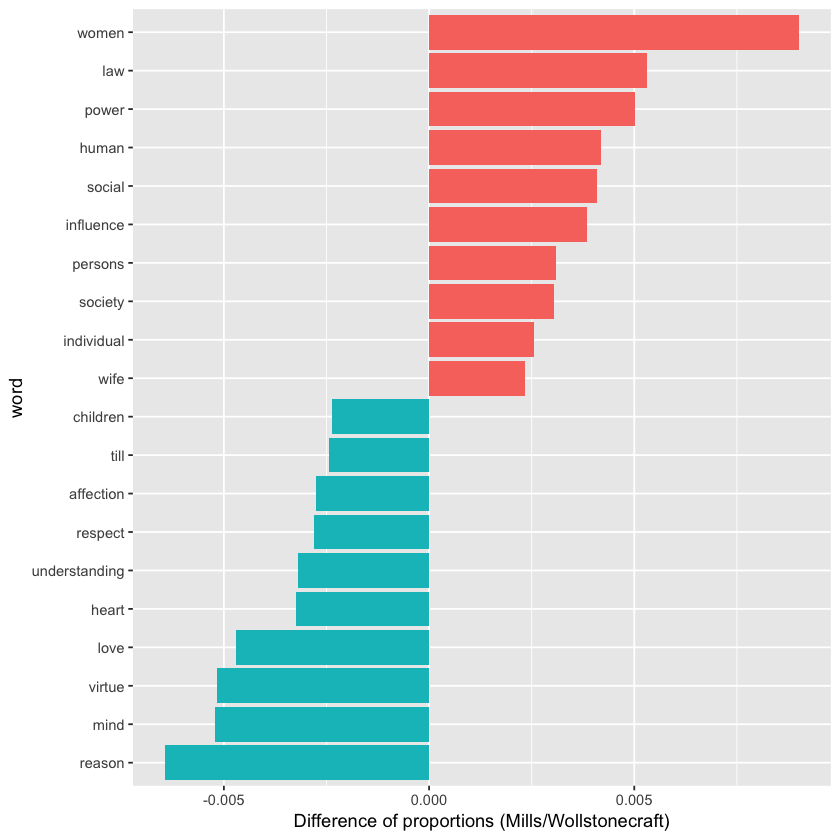

In [98]:
word_proportions %>%
    group_by(diffprop < 0) %>%
    top_n(10, abs(diffprop)) %>%
    ungroup() %>%
    mutate(word = reorder(word, diffprop)) %>%
    ggplot(aes(word, diffprop, fill = diffprop < 0)) +
    geom_col(show.legend = FALSE) + 
    coord_flip() + 
    ylab("Difference of proportions (Mills/Wollstonecraft)")

We see similar results but see that the scale of the use of *women* and *reason* is larger than other words which differentiate these two authors.

Your turn again!

#### Exercise 3

1. Let's load *Up from Slavery* by Booker T. Washington using `gutenbergr`. The ID is 2376. Store it in a variable called `slavery`.
2. Generate the tidy data frame without stop words. Store in `tidy_slavery`.
3. Merge the two, denoted by author. Store in `tidy_compare`.
4. Generate a difference of proportions. What differs the mos

### Generating topic models with `stm`

In [ ]:
library(stm)
library(stringr)

In [ ]:
sotu_tweets <- read_csv('https://github.com/alexhannna/unm-text-as-data/sotu-text.csv', 
                        col_names = c('tweet'))

In [ ]:
sotu_tweets$id <- seq(1, nrow(sotu_tweets))

In [ ]:
## remove links
## unnest
## remove stopwords
tidy_sotu_tweets <- sotu_tweets %>% 
    mutate(tweet = str_replace(tweet, 'https://.+', '')) %>%
    unnest_tokens(word, tweet) %>%
    anti_join(stop_words) %>%
    filter(word != "sotu")

In [ ]:
sotu_dfm <- tidy_sotu_tweets %>% 
    count(id, word, sort = TRUE) %>%
    cast_dfm(id, word, n)

In [ ]:
topic_model <- stm(sotu_dfm, K = 10, 
                   verbose = FALSE, init.type = "Spectral")

In [ ]:
summary(topic_model)

In [ ]:
td_beta <- tidy(topic_model)

In [ ]:
td_beta %>%
    group_by(topic) %>%
    top_n(10, beta) %>%
    ungroup() %>%
    mutate(topic = paste0("Topic ", topic), term) %>%
    ggplot(aes(term, beta, fill = as.factor(topic))) +
    geom_col(alpha = 0.8, show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") +
    coord_flip() +
    labs(x = NULL, y = expression(beta),
         title = "Highest word probabilities for each topic",
         subtitle = "Different words are associated with different topics")